## Prétraitement

In [19]:
import sys
sys.path.insert(0, '../')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from src.data import load_data_excel, convert_numeric_columns
from src.features import encode_categorical_feature, onehot_encode_categorical_feature, get_simplified_names
from src.experiments import (
    prepare_data_random_split, train_xgboost_models
)
from src.visu import plot_ml_results

# Load data
data = load_data_excel('../data/sources/Donnees_IA_2025.xlsx')

# Define variables
vars_expl = [
    "MS % brut", "PB % brut", "CB % brut", "MGR % brut", "MM % brut",
    "NDF % brut", "ADF % brut", "Lignine % brut", "Amidon % brut", "Sucres % brut"
]

vars_cibles = [
    "EB (kcal) kcal/kg brut", "ED porc croissance (kcal) kcal/kg brut",
    "EM porc croissance (kcal) kcal/kg brut", "EN porc croissance (kcal) kcal/kg brut",
    "EMAn coq (kcal) kcal/kg brut", "EMAn poulet (kcal) kcal/kg brut",
    "UFL 2018 par kg brut", "UFV 2018 par kg brut", "PDIA 2018 g/kg brut",
    "PDI 2018 g/kg brut", "BalProRu 2018 g/kg brut"
]

# Convert numeric columns
data = convert_numeric_columns(data, vars_expl + vars_cibles)

# Get simplified names
simplified_names = get_simplified_names()

print(f" Data loaded: {len(data)} observations")

 Data loaded: 6376 observations


## Régression XGBoost et test sur les valeurs de table (In Distribution) - Importance des caractéristiques et test de robustesse

Testez comment les performances du modèle varient en fonction des différentes caractéristiques d'entrée et des encodages catégoriels.

### Scenario 1: Toutes les variables physico-chimiques (sans encodage catégoriel)

In [20]:
# Prepare data with random split
X_train_all, X_test_all, y_train_all, y_test_all = prepare_data_random_split(
    data, vars_expl, vars_cibles, test_size=0.2, random_state=42
)

# Train XGBoost models
results_all, metrics_all, models_all = train_xgboost_models(
    X_train_all, X_test_all, y_train_all, y_test_all,
    vars_cibles, simplified_names, random_state=42
)

print("\nScenario 1: All Chemical Composition Variables")
print(f"Train size: {len(X_train_all)}, Test size: {len(X_test_all)}")
print(f"R² variance weighted: {metrics_all['R2_variance_weighted']:.4f}")
print(f"R² uniform: {metrics_all['R2_uniform']:.4f}")
print(f"R² min: {metrics_all['R2_min']:.4f}")
print("\nDetailed results:")
print(results_all.to_string(index=False))


Scenario 1: All Chemical Composition Variables
Train size: 5100, Test size: 1276
R² variance weighted: 0.9899
R² uniform: 0.9903
R² min: 0.9879

Detailed results:
Variable cible   MAE  RMSE     R2
            EB 31.02 52.96 0.9928
       ED porc 49.31 93.01 0.9879
       EM porc 45.48 84.46 0.9892
       EN porc 35.00 58.44 0.9933
      EMAn coq 48.93 82.59 0.9895
   EMAn poulet 49.61 84.54 0.9883
           UFL  0.02  0.03 0.9899
           UFV  0.02  0.04 0.9880
          PDIA  2.73  8.02 0.9906
           PDI  2.77  8.13 0.9900
      BalProRu  3.35  7.53 0.9939


### Scenario 2: Varibales MS et PB uniquement (variables les plus couramment connues par les utilisateurs)

In [21]:
# Scenario 2: Reduced features
features_reduced = ["MS % brut", "PB % brut"]
X_train_reduced, X_test_reduced, y_train_reduced, y_test_reduced = prepare_data_random_split(
    data, features_reduced, vars_cibles, test_size=0.2, random_state=42
)

results_reduced, metrics_reduced, models_reduced = train_xgboost_models(
    X_train_reduced, X_test_reduced, y_train_reduced, y_test_reduced,
    vars_cibles, simplified_names, random_state=42
)

print("\nScenario 2: MS + PB Only")
print(f"Train size: {len(X_train_reduced)}, Test size: {len(X_test_reduced)}")
print(f"R² variance weighted: {metrics_reduced['R2_variance_weighted']:.4f}")
print(f"Performance drop vs all features: {metrics_all['R2_variance_weighted'] - metrics_reduced['R2_variance_weighted']:+.4f}")
print(results_reduced.to_string(index=False))


Scenario 2: MS + PB Only
Train size: 5100, Test size: 1276
R² variance weighted: 0.4208
Performance drop vs all features: +0.5691
Variable cible    MAE   RMSE     R2
            EB 225.91 364.43 0.6596
       ED porc 411.00 607.56 0.4855
       EM porc 412.11 609.83 0.4392
       EN porc 377.90 569.02 0.3650
      EMAn coq 451.91 667.24 0.3147
   EMAn poulet 440.80 647.38 0.3139
           UFL   0.14   0.22 0.4336
           UFV   0.17   0.25 0.4058
          PDIA  15.37  27.80 0.8875
           PDI  15.28  27.57 0.8854
      BalProRu  16.96  28.96 0.9105


### Scenario 3: Nom Only (One-Hot Encoded)

In [22]:
# Scenario 3: Nom only (One-Hot Encoded)
X_train_nom_ohe, X_test_nom_ohe, y_train_nom_ohe, y_test_nom_ohe = prepare_data_random_split(
    data, [], vars_cibles, test_size=0.2, random_state=42
)

# Keep track of indices for one-hot encoding
indices_train_nom = X_train_nom_ohe.index
indices_test_nom = X_test_nom_ohe.index

# Add one-hot encoded Nom feature
X_train_nom_ohe, X_test_nom_ohe = onehot_encode_categorical_feature(
    X_train_nom_ohe, X_test_nom_ohe, data, "Nom", indices_train_nom, indices_test_nom, drop_first=False
)

# Clean column names to remove special characters
X_train_nom_ohe.columns = X_train_nom_ohe.columns.str.replace('[', '_', regex=False).str.replace(']', '_', regex=False).str.replace('<', '_', regex=False)
X_test_nom_ohe.columns = X_test_nom_ohe.columns.str.replace('[', '_', regex=False).str.replace(']', '_', regex=False).str.replace('<', '_', regex=False)

results_nom_ohe, metrics_nom_ohe, models_nom_ohe = train_xgboost_models(
    X_train_nom_ohe, X_test_nom_ohe, y_train_nom_ohe, y_test_nom_ohe,
    vars_cibles, simplified_names, random_state=42
)

print("\nScenario 3: Nom Only (One-Hot Encoded)")
print(f"Train size: {len(X_train_nom_ohe)}, Test size: {len(X_test_nom_ohe)}")
print(f"R² variance weighted: {metrics_nom_ohe['R2_variance_weighted']:.4f}")
print(f"Number of features (One-Hot encoded Nom): {X_train_nom_ohe.shape[1]}")
print(results_nom_ohe.to_string(index=False))


Scenario 3: Nom Only (One-Hot Encoded)
Train size: 5100, Test size: 1276
R² variance weighted: 0.9333
Number of features (One-Hot encoded Nom): 73
Variable cible    MAE   RMSE     R2
            EB 102.12 155.62 0.9379
       ED porc 144.08 229.35 0.9267
       EM porc 138.04 220.79 0.9265
       EN porc 108.44 173.34 0.9411
      EMAn coq 127.78 204.76 0.9355
   EMAn poulet 123.71 198.58 0.9354
           UFL   0.04   0.07 0.9419
           UFV   0.05   0.08 0.9432
          PDIA   5.54  10.94 0.9826
           PDI   5.86  11.41 0.9804
      BalProRu  11.65  19.06 0.9612


### Comparative Results

In [28]:
# Create comparison DataFrame for first 3 scenarios
comparison_df = pd.DataFrame({
    'Scenario': [
        'Toutes les variables physico-chimiques',
        'Seules MS + PB',
        'Nom Only (OHE)'
    ],
    'R² Variance Weighted': [
        metrics_all['R2_variance_weighted'],
        metrics_reduced['R2_variance_weighted'],
        metrics_nom_ohe['R2_variance_weighted']
    ],
    'R² Std Dev': [
        results_all['R2'].std(),
        results_reduced['R2'].std(),
        results_nom_ohe['R2'].std()
    ]
})


Table de comparaison des performances (R² Variance Weighted) pour les 3 premiers scénarios :
                              Scenario  R² Variance Weighted  R² Std Dev
Toutes les variables physico-chimiques                0.9899    0.002132
                        Seules MS + PB                0.4208    0.237540
                        Nom Only (OHE)                0.9333    0.019596


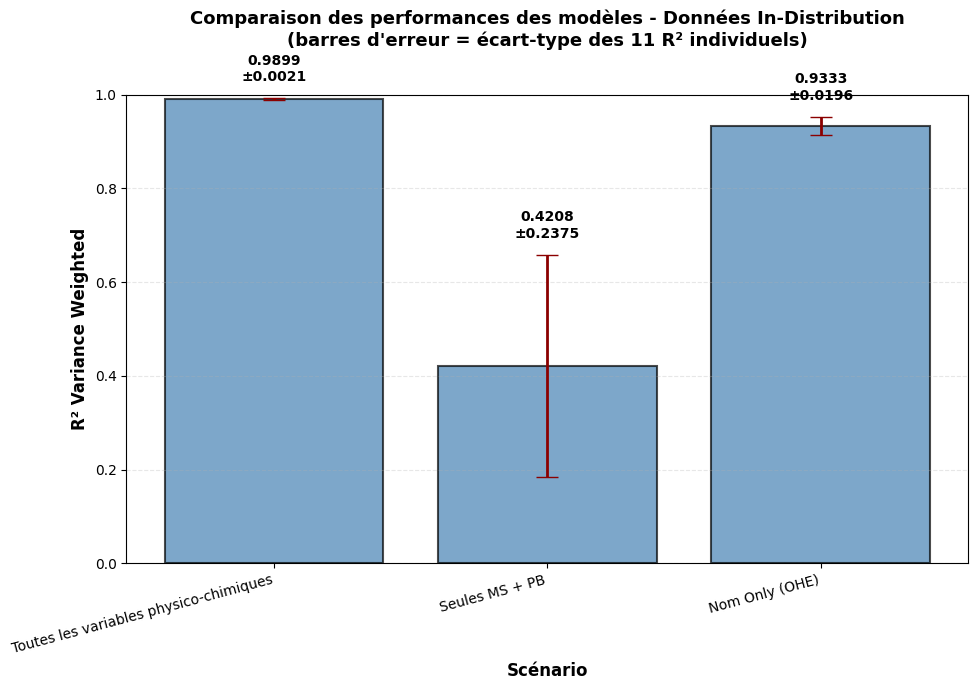

In [36]:

print("\n" + "="*80)
print("Table de comparaison des performances (R² Variance Weighted) pour les 3 premiers scénarios :")
print("="*80)
print(comparison_df.to_string(index=False))

# Plot with error bars showing std dev of R² across 11 targets
fig, ax = plt.subplots(figsize=(10, 7))

x_pos = np.arange(len(comparison_df))
ax.bar(x_pos, comparison_df['R² Variance Weighted'], 
       yerr=comparison_df['R² Std Dev'],
       capsize=8, alpha=0.7, color='steelblue', edgecolor='black', linewidth=1.5,
       error_kw={'linewidth': 2, 'ecolor': 'darkred'})

ax.set_ylabel('R² Variance Weighted', fontsize=12, fontweight='bold')
ax.set_xlabel('Scénario', fontsize=12, fontweight='bold')
ax.set_title('Comparaison des performances des modèles - Données In-Distribution\n(barres d\'erreur = écart-type des 11 R² individuels)', 
             fontsize=13, fontweight='bold', pad=35)
ax.set_xticks(x_pos)
ax.set_xticklabels(comparison_df['Scenario'], rotation=15, ha='right')
ax.grid(axis='y', alpha=0.3, linestyle='--')
ax.set_ylim(0, 1)

# Add value labels on bars
for i, (val, std) in enumerate(zip(comparison_df['R² Variance Weighted'], comparison_df['R² Std Dev'])):
    ax.text(i, val + std + 0.03, f'{val:.4f}\n±{std:.4f}', 
            ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

### Scenario 4: Classe Only (Encoded)

In [37]:
# Scenario 4: Classe only (One-Hot Encoded)
X_train_classe, X_test_classe, y_train_classe, y_test_classe = prepare_data_random_split(
    data, [], vars_cibles, test_size=0.2, random_state=42
)

# Keep track of indices for one-hot encoding
indices_train_c = X_train_classe.index
indices_test_c = X_test_classe.index

# Add one-hot encoded Classe feature
X_train_classe, X_test_classe = onehot_encode_categorical_feature(
    X_train_classe, X_test_classe, data, "Classe", indices_train_c, indices_test_c, drop_first=False
)

# Clean column names to remove special characters
X_train_classe.columns = X_train_classe.columns.str.replace('[', '_', regex=False).str.replace(']', '_', regex=False).str.replace('<', '_', regex=False)
X_test_classe.columns = X_test_classe.columns.str.replace('[', '_', regex=False).str.replace(']', '_', regex=False).str.replace('<', '_', regex=False)

results_classe, metrics_classe, models_classe = train_xgboost_models(
    X_train_classe, X_test_classe, y_train_classe, y_test_classe,
    vars_cibles, simplified_names, random_state=42
)

print("\nScenario 4: Classe Only (One-Hot Encoded)")
print(f"Train size: {len(X_train_classe)}, Test size: {len(X_test_classe)}")
print(f"R² variance weighted: {metrics_classe['R2_variance_weighted']:.4f}")
print(f"Number of features (One-Hot encoded Classe): {X_train_classe.shape[1]}")
print(results_classe.to_string(index=False))


Scenario 4: Classe Only (One-Hot Encoded)
Train size: 5100, Test size: 1276
R² variance weighted: 0.4393
Number of features (One-Hot encoded Classe): 15
Variable cible    MAE   RMSE     R2
            EB 328.57 447.32 0.4871
       ED porc 495.93 640.94 0.4274
       EM porc 475.49 611.22 0.4367
       EN porc 396.26 507.10 0.4957
      EMAn coq 486.85 614.69 0.4184
   EMAn poulet 483.06 605.53 0.3997
           UFL   0.16   0.21 0.4719
           UFV   0.18   0.24 0.4730
          PDIA  36.49  59.80 0.4795
           PDI  36.53  59.33 0.4691
      BalProRu  48.81  69.86 0.4790


### Scenario 5: Toutes les variables chimiques + Nom (Encodés)

In [38]:
# Scenario 5: All chemical features + Nom (One-Hot Encoded)
X_train_nom, X_test_nom, y_train_nom, y_test_nom = prepare_data_random_split(
    data, vars_expl, vars_cibles, test_size=0.2, random_state=42
)

# Keep track of indices for one-hot encoding
indices_train_nom = X_train_nom.index
indices_test_nom = X_test_nom.index

# Add one-hot encoded Nom feature
X_train_nom, X_test_nom = onehot_encode_categorical_feature(
    X_train_nom, X_test_nom, data, "Nom", indices_train_nom, indices_test_nom, drop_first=False
)

# Clean column names to remove special characters
X_train_nom.columns = X_train_nom.columns.str.replace('[', '_', regex=False).str.replace(']', '_', regex=False).str.replace('<', '_', regex=False)
X_test_nom.columns = X_test_nom.columns.str.replace('[', '_', regex=False).str.replace(']', '_', regex=False).str.replace('<', '_', regex=False)

results_nom, metrics_nom, models_nom = train_xgboost_models(
    X_train_nom, X_test_nom, y_train_nom, y_test_nom,
    vars_cibles, simplified_names, random_state=42
)

print("\nScenario 5: All Chemical Features + Nom (One-Hot Encoded)")
print(f"Train size: {len(X_train_nom)}, Test size: {len(X_test_nom)}")
print(f"R² variance weighted: {metrics_nom['R2_variance_weighted']:.4f}")
print(f"Number of features (Chemical + One-Hot encoded Nom): {X_train_nom.shape[1]}")
print(results_nom.to_string(index=False))


Scenario 5: All Chemical Features + Nom (One-Hot Encoded)
Train size: 5100, Test size: 1276
R² variance weighted: 0.9914
Number of features (Chemical + One-Hot encoded Nom): 83
Variable cible   MAE  RMSE     R2
            EB 30.21 51.78 0.9931
       ED porc 46.73 78.28 0.9915
       EM porc 44.47 80.26 0.9903
       EN porc 33.63 53.53 0.9944
      EMAn coq 49.05 80.26 0.9901
   EMAn poulet 46.46 76.77 0.9904
           UFL  0.02  0.03 0.9894
           UFV  0.02  0.03 0.9908
          PDIA  1.87  5.60 0.9954
           PDI  2.12  6.30 0.9940
      BalProRu  2.69  5.64 0.9966


### Scenario 6: MS + PB + Nom (Encoded)

In [39]:
# Scenario 6: MS + PB + Nom (One-Hot Encoded)
features_mspb = ["MS % brut", "PB % brut"]
X_train_mspb_nom, X_test_mspb_nom, y_train_mspb_nom, y_test_mspb_nom = prepare_data_random_split(
    data, features_mspb, vars_cibles, test_size=0.2, random_state=42
)

# Keep track of indices for one-hot encoding
indices_train_mspb = X_train_mspb_nom.index
indices_test_mspb = X_test_mspb_nom.index

# Add one-hot encoded Nom feature
X_train_mspb_nom, X_test_mspb_nom = onehot_encode_categorical_feature(
    X_train_mspb_nom, X_test_mspb_nom, data, "Nom", indices_train_mspb, indices_test_mspb, drop_first=False
)

# Clean column names to remove special characters
X_train_mspb_nom.columns = X_train_mspb_nom.columns.str.replace('[', '_', regex=False).str.replace(']', '_', regex=False).str.replace('<', '_', regex=False)
X_test_mspb_nom.columns = X_test_mspb_nom.columns.str.replace('[', '_', regex=False).str.replace(']', '_', regex=False).str.replace('<', '_', regex=False)

results_mspb_nom, metrics_mspb_nom, models_mspb_nom = train_xgboost_models(
    X_train_mspb_nom, X_test_mspb_nom, y_train_mspb_nom, y_test_mspb_nom,
    vars_cibles, simplified_names, random_state=42
)

print("\nScenario 6: MS + PB + Nom (One-Hot Encoded)")
print(f"Train size: {len(X_train_mspb_nom)}, Test size: {len(X_test_mspb_nom)}")
print(f"R² variance weighted: {metrics_mspb_nom['R2_variance_weighted']:.4f}")
print(f"Number of features (MS + PB + One-Hot encoded Nom): {X_train_mspb_nom.shape[1]}")
print(results_mspb_nom.to_string(index=False))


Scenario 6: MS + PB + Nom (One-Hot Encoded)
Train size: 5100, Test size: 1276
R² variance weighted: 0.9648
Number of features (MS + PB + One-Hot encoded Nom): 75
Variable cible    MAE   RMSE     R2
            EB  67.65 113.59 0.9669
       ED porc 106.44 159.62 0.9645
       EM porc 103.42 156.12 0.9632
       EN porc  84.95 130.90 0.9664
      EMAn coq  99.96 154.91 0.9631
   EMAn poulet  95.85 146.16 0.9650
           UFL   0.03   0.05 0.9677
           UFV   0.04   0.06 0.9678
          PDIA   1.41   3.52 0.9982
           PDI   1.65   3.52 0.9981
      BalProRu   2.21   3.59 0.9986


### Comparaison total des différents scénarios

In [42]:
# Extended comparison with all 6 scenarios
comparison_all_df = pd.DataFrame({
    'Scenario': [
        'Toutes les variables physico-chimiques',
        'Seules MS + PB',
        'Nom uniquement (OHE)',
        'Classe uniquement (OHE)',
        'Toutes variables chimiques + Nom (OHE)',
        'MS + PB + Nom (OHE)'
    ],
    'R² Variance Weighted': [
        metrics_all['R2_variance_weighted'],
        metrics_reduced['R2_variance_weighted'],
        metrics_nom_ohe['R2_variance_weighted'],
        metrics_classe['R2_variance_weighted'],
        metrics_nom['R2_variance_weighted'],
        metrics_mspb_nom['R2_variance_weighted']
    ],
    'R² Std Dev': [
        results_all['R2'].std(),
        results_reduced['R2'].std(),
        results_nom_ohe['R2'].std(),
        results_classe['R2'].std(),
        results_nom['R2'].std(),
        results_mspb_nom['R2'].std()
    ]
})

# Sort by R² in descending order (highest to lowest)
comparison_all_df = comparison_all_df.sort_values('R² Variance Weighted', ascending=False).reset_index(drop=True)


EXTENDED COMPARISON TABLE - All 6 Scenarios (sorted by R² descending)
                              Scenario  R² Variance Weighted  R² Std Dev
Toutes variables chimiques + Nom (OHE)                0.9914    0.002444
Toutes les variables physico-chimiques                0.9899    0.002132
                   MS + PB + Nom (OHE)                0.9648    0.015368
                  Nom uniquement (OHE)                0.9333    0.019596
               Classe uniquement (OHE)                0.4393    0.031733
                        Seules MS + PB                0.4208    0.237540


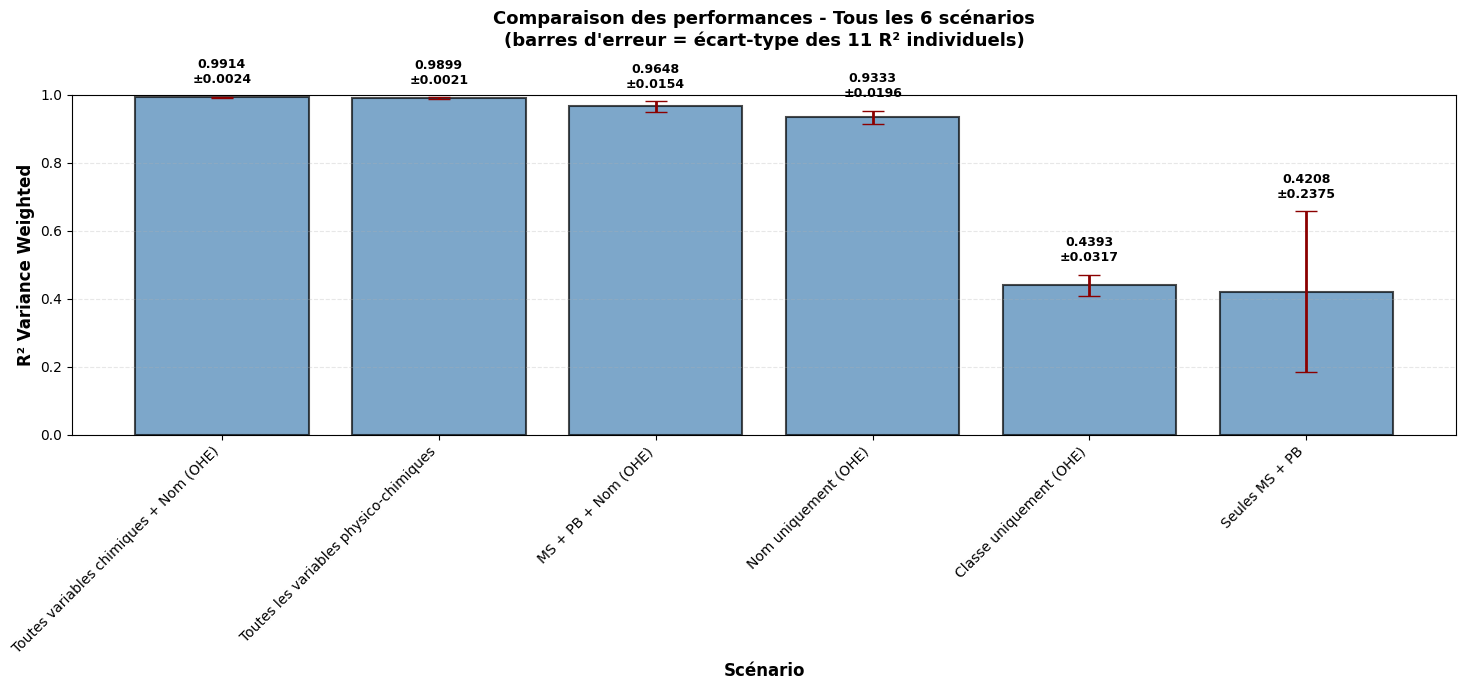

In [44]:

print("\n" + "="*80)
print("EXTENDED COMPARISON TABLE - All 6 Scenarios (sorted by R² descending)")
print("="*80)
print(comparison_all_df.to_string(index=False))

# Plot all 6 scenarios with error bars
fig, ax = plt.subplots(figsize=(15, 7))

x_pos = np.arange(len(comparison_all_df))
ax.bar(x_pos, comparison_all_df['R² Variance Weighted'], 
       yerr=comparison_all_df['R² Std Dev'],
       capsize=8, alpha=0.7, color='steelblue', edgecolor='black', linewidth=1.5,
       error_kw={'linewidth': 2, 'ecolor': 'darkred'})

ax.set_ylabel('R² Variance Weighted', fontsize=12, fontweight='bold')
ax.set_xlabel('Scénario', fontsize=12, fontweight='bold')
ax.set_title('Comparaison des performances - Tous les 6 scénarios\n(barres d\'erreur = écart-type des 11 R² individuels)', 
             fontsize=13, fontweight='bold', pad=35)
ax.set_xticks(x_pos)
ax.set_xticklabels(comparison_all_df['Scenario'], rotation=45, ha='right')
ax.grid(axis='y', alpha=0.3, linestyle='--')
ax.set_ylim(0, 1)

# Add value labels on bars
for i, (val, std) in enumerate(zip(comparison_all_df['R² Variance Weighted'], comparison_all_df['R² Std Dev'])):
    ax.text(i, val + std + 0.03, f'{val:.4f}\n±{std:.4f}', 
            ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.show()

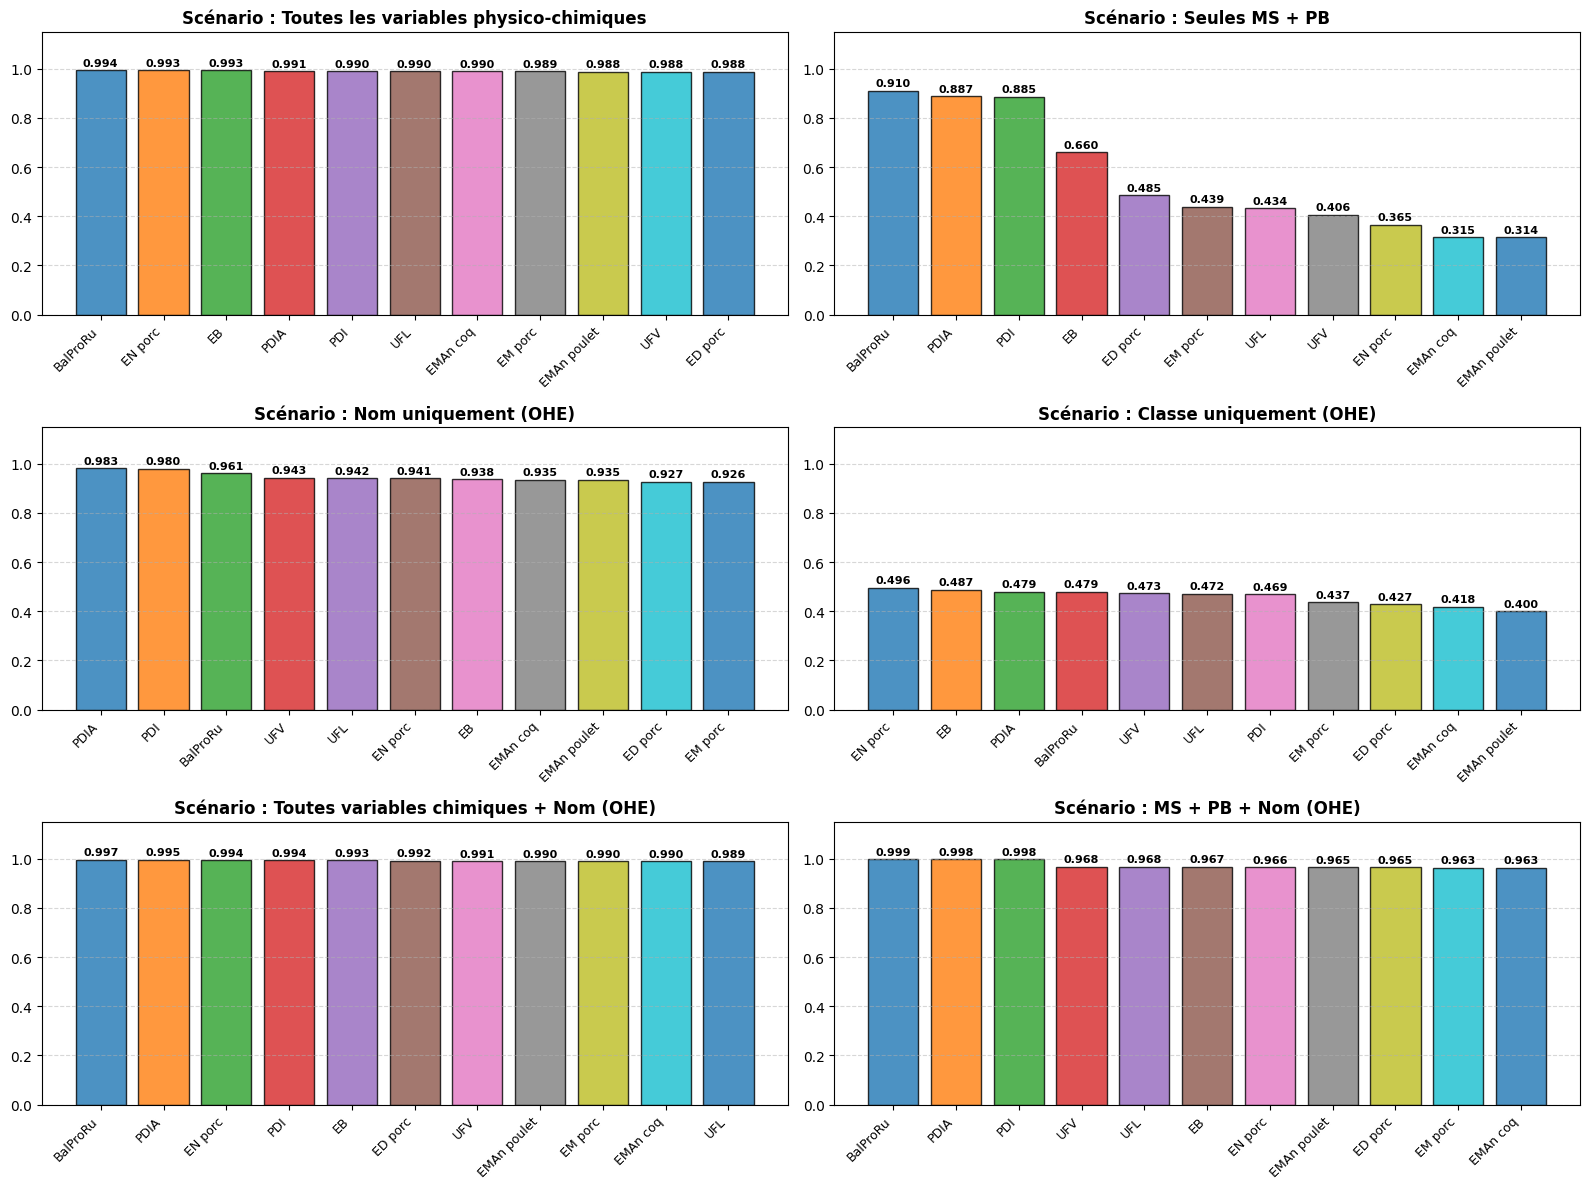

In [46]:
# Grid of R² by target variable for all 6 scenarios
all_detailed_results = {
    'Toutes les variables physico-chimiques': results_all,
    'Seules MS + PB': results_reduced,
    'Nom uniquement (OHE)': results_nom_ohe,
    'Classe uniquement (OHE)': results_classe,
    'Toutes variables chimiques + Nom (OHE)': results_nom,
    'MS + PB + Nom (OHE)': results_mspb_nom
}

# Alternative visualization for detailed results
fig = plot_ml_results(
    all_detailed_results,
    y_col='R2',
    figsize=(16, 12)
)
plt.show()